# Exercise 2: Solving the Laplace Equation

## Introduction 
In this notebook, we will solve the Laplace equation on a square domain with various boundary conditions. We will explore different numerical methods including sparse matrix techniques and the Jacobi iterative method, and visualize the results.

Let's get started by setting up the problem.

## Problem Description

The Laplace equation is a second-order partial differential equation widely used in physics and engineering. We will solve it on a square domain with side length L = 1m and Dirichlet boundary conditions.

![Dirichlet boundary conditions example](./images/exercise_2.png)

We will discretize the domain into a grid and set up the system of equations to be solved.

## Understanding the Laplace equation
The Laplace equation in two dimensions is given by $$ \frac{\partial^2 V}{\partial x^2} + \frac{\partial^2 V}{\partial y^2} = 0 $$
This equation describes the potential $ V(x, y) $ in a region where there are no charges. The goal is to solve this equation over 
a square domain with side length L = 1 meter, given certain boundary conditions.

## Discretizing the Laplace Equation
### Finite Difference Method
To solve the Laplace equation numerically, we discretize the continuous domain into a grid of points. The second derivative can be approximated using finite differences:

$$ \frac{\partial^2 V}{\partial x^2} \approx \frac{V_{i+1,j} - 2V_{i,j} + V_{i-1,j}}{\Delta x^2} $$

where $ \Delta x $ is the grid spacing. For the $y$-direction, we do the same thing.
### Constructing the Matrix Equation
Using finite differences, we convert the Laplace equation into a system of linear equations: $$ A V = b $$
Here, **$A$** is a sparse matrix that encodes the finite difference template, **$V$** is the vector of unknown potentials, and **$b$** contains the boundary conditions.

## Method 1: Implementing the Sparse Matrix method

In this section, we will solve the Laplace equation using a sparse matrix approach. Sparse matrices are efficient data structures for representing large matrices that contain many zeros, allowing us to save memory and computation time by only storing the non-zero entries.

We begin by discretizing the 2D domain into an $ N×N $ grid, where each grid point corresponds to a discrete approximation of the potential function $V(x,y)$. The Laplace equation in two dimensions can be approximated using finite differences, which converts the continuous equation into a set of linear equations.

These linear equations can be expressed in matrix form as $AV=b$, where **$A$** is the coefficient matrix, **$V$** is the vector of unknown potentials at each grid point, and **$b$** contains the known boundary conditions. The matrix **$A$** is sparse because each equation typically involves only a few neighboring grid points, leading to many zero entries.

To construct the sparse matrix **$A$**, we first create a tridiagonal matrix, referred to as `B_matrix`, which represents the finite difference stencil for the internal grid points (those not on the boundary). We then use Kronecker products with identity matrices to expand this into the full matrix **$A$**, applying the finite difference stencil across the entire grid.

Incorporating the boundary conditions involves modifying both the matrix **$A$** and the vector **$b$**. For Dirichlet boundary conditions, where the potential is fixed on the boundaries, the corresponding entries in **$b$** are set to the boundary potential values, and the matrix **$A$** is adjusted accordingly to enforce these conditions.

Once the system of linear equations is set up, we solve it using numpy's `linalg.solve` function, which efficiently handles the sparse structure of the matrix. The solution vector **$V$** is then reshaped into an $NxN$ grid, representing the potential field across the entire domain.

This method is particularly advantageous for large grid sizes because it efficiently manages the computational complexity and memory requirements inherent in solving elliptic partial differential equations like the Laplace equation. Now, let's implement this in code.

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse

def solve_sparse_matrix(N):
    V_boundary = 100  # Boundary potential in volts
    alpha = 1  # Parameter for matrix construction
    
    # Main diagonal and off-diagonals of the matrix
    main_diag = 2*(1 + alpha)*np.ones(N)
    off_diag = -1*np.ones(N-1)
    
    # Construct the matrix B for the internal points
    B_matrix = sparse.diags([main_diag, off_diag, off_diag], [0, -1, 1], shape=(N-2, N-2)).toarray()
    B_matrix = sparse.block_diag(([1], B_matrix, [1])).toarray()
    
    # Identity matrices for tensor product
    Identity_full = sparse.eye(N).toarray()
    Identity_partial = sparse.diags([np.zeros(N), -np.ones(N), -np.ones(N)], [0, -1, 1], shape=(N, N)).toarray()
    Identity_adjusted = np.identity(N-2)
    Identity_adjusted = sparse.block_diag(([0], Identity_adjusted, [0])).toarray()
    
    # Construct the full matrix A using Kronecker products
    A_matrix = sparse.kron(Identity_full, B_matrix).toarray() + sparse.kron(Identity_partial, Identity_adjusted).toarray()
    
    # Modify matrix A for boundary conditions
    A_matrix = sparse.block_diag((np.identity(N), A_matrix)).toarray()
    A_matrix[N:2*N, :N] = -1*Identity_adjusted
        
    # Vector of boundary conditions
    b_vector = np.zeros((N+1)*N)
    b_vector[0:N] = V_boundary  # Applying boundary condition on the first row
    
    # Solve the system A*V = b
    solution = np.linalg.solve(A_matrix, b_vector)
    solution = solution[:-N].reshape(N, N)
    return solution

# Define the grid size
N = 50

# Solve the Laplace equation using the sparse matrix method
solution_sparse = solve_sparse_matrix(N)

## Visualizing the results
Now that we have computed the solution to the Laplace equation, we need to visualize the potential distribution across the domain to understand how it varies spatially. We will use two types of plots: contour plots and heatmaps.

### Contour Plot
A contour plot shows lines of constant potential, helping to visualize the gradients and equipotential lines in the solution. It connects points with the same potential value, making it easier to see how the potential changes across the domain.

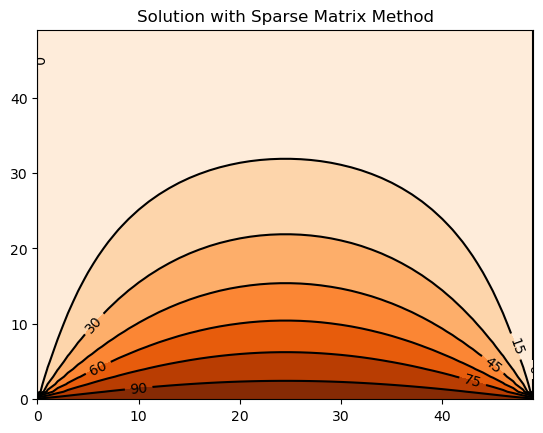

In [15]:
# Determine the range of potential values
vmin, vmax = solution_sparse.min(), solution_sparse.max()

# Contour plot
plt.figure()
plt.contourf(solution_sparse, alpha=1, cmap=plt.cm.Oranges, vmin=vmin, vmax=vmax)
C = plt.contour(solution_sparse, colors='black', vmin=vmin, vmax=vmax)
plt.clabel(C, inline=1)
plt.title('Solution with Sparse Matrix Method')
plt.show()

### Heatmap (imshow)
A heatmap provides a color-coded representation of the potential values across the grid. It is useful for quickly identifying regions of high and low potential, giving an immediate sense of the potential distribution.

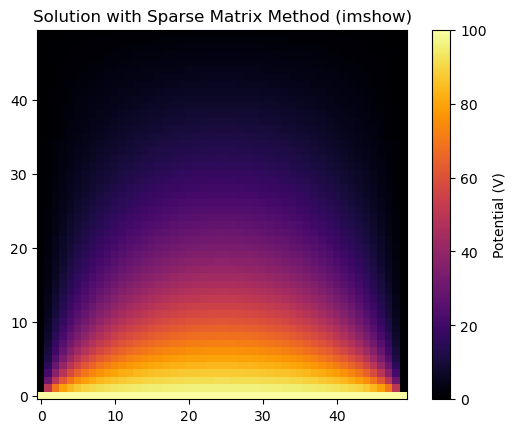

In [16]:
# Heatmap using imshow
plt.figure()
plt.imshow(solution_sparse, cmap=plt.cm.inferno, origin='lower', vmin=vmin, vmax=vmax)
plt.title('Solution with Sparse Matrix Method (imshow)')
plt.colorbar(label='Potential (V)')
plt.show()

In these visualizations, the contour plot gives us a clear view of the potential field's topology, while the heatmap offers a quick and intuitive understanding of the potential distribution across the grid. Together, they provide complementary insights into the solution

## Method 2: Implementing the Jacobi Method
In this section, we will solve the Laplace equation using the Jacobi iterative method. The Jacobi method is a straightforward iterative technique for solving linear systems of equations. It updates the potential at each grid point based on the average of its neighboring points until the solution converges.

The Jacobi method is particularly useful for solving large systems where direct methods like matrix inversion may be computationally expensive. It is also easy to implement, making it a good introduction to iterative solvers.

To implement the Jacobi method, we follow these steps:

1. **Initialization**: Start by initializing the grid with random potential values. Apply the boundary conditions directly to the grid, setting fixed potential values where necessary.

2. **Iterative update**: For each interior grid point (i.e., points not on the boundary), update its potential by taking the average of its four neighbors (up, down, left, and right). This process is repeated until the maximum change in potential across the grid is smaller than a predefined tolerance, indicating that the solution has converged.

3. **Convergence check**: After each iteration, check the maximum difference between the old and new potential values across all grid points. If this difference is less than the specified tolerance, the solution is considered converged.

Let's implement this in code:

In [17]:
def jacobi_method(N):
    V_boundary = 100  # Boundary potential in volts
    tolerance = 1e-3  # Convergence tolerance
    potential_matrix = np.random.rand(N, N)  # Initialize the grid with random values
    
    # Apply boundary conditions
    potential_matrix[0, :] = V_boundary  # Top boundary
    potential_matrix[1:, 0] = 0          # Left boundary
    potential_matrix[N-1, 1:] = 0        # Bottom boundary
    potential_matrix[N-1, :] = 0         # Bottom boundary (repeated to include all points)
    
    # Iterative method to solve the system
    while True:
        max_error = 0
        for i in range(1, N-1):
            for j in range(1, N-1):
                old_value = potential_matrix[i, j]
                potential_matrix[i, j] = 0.25 * (potential_matrix[i+1, j] + potential_matrix[i-1, j] +
                                                 potential_matrix[i, j+1] + potential_matrix[i, j-1])
                max_error = max(max_error, abs(potential_matrix[i, j] - old_value))
        if max_error < tolerance:
            break
    
    return potential_matrix

# Define the grid size
N = 50

# Solve the Laplace equation using the Jacobi method
solution_jacobi = jacobi_method(N)

## Visualization
We proceed as before:

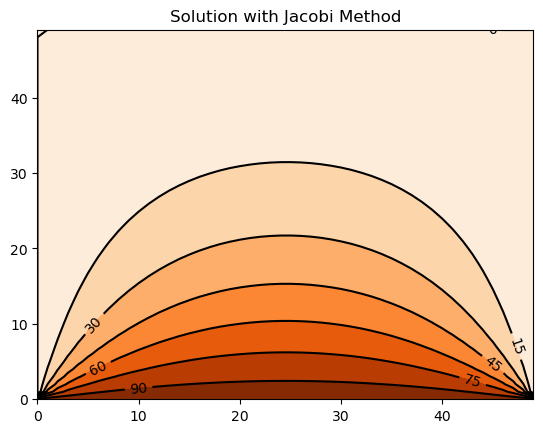

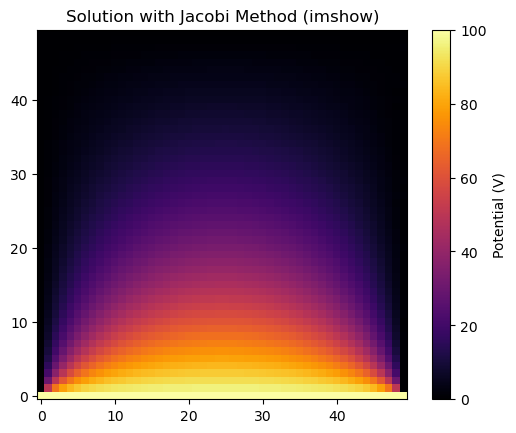

In [18]:
# Determine the range of potential values for Jacobi solution
vmin, vmax = solution_jacobi.min(), solution_jacobi.max()

# Contour plot for Jacobi solution
plt.figure()
plt.contourf(solution_jacobi, alpha=1, cmap=plt.cm.Oranges, vmin=vmin, vmax=vmax)
C = plt.contour(solution_jacobi, colors='black', vmin=vmin, vmax=vmax)
plt.clabel(C, inline=1)
plt.title('Solution with Jacobi Method')
plt.show()

# Heatmap using imshow for Jacobi solution
plt.figure()
plt.imshow(solution_jacobi, cmap=plt.cm.inferno, origin='lower', vmin=vmin, vmax=vmax)
plt.title('Solution with Jacobi Method (imshow)')
plt.colorbar(label='Potential (V)')
plt.show()

# Method 3: Implementing Neumann Boundary Conditions

In this section, we will modify our approach to solve the Laplace equation with Neumann boundary conditions. Neumann boundary conditions specify the derivative of the potential on the boundary rather than the potential itself. For this problem, we will impose $ \frac{\partial V}{\partial y} = 0 $ on the vertical walls of the domain, meaning that the potential gradient is zero (no flux across the boundary).

To handle Neumann boundary conditions, we adjust the construction of the sparse matrix. Specifically, we modify the finite difference stencil at the boundaries to enforce that the derivative of the potential is zero.

Let's implement this in code:

In [19]:
def solve_sparse_matrix_neumann(N):
    V_boundary = 100  # Boundary potential in volts
    alpha = 1  # Parameter for matrix construction
    
    # Main diagonal and off-diagonals of the matrix
    main_diag = 2 * (1 + alpha) * np.ones(N)
    off_diag = -1 * np.ones(N-1)
    
    # Construct matrix B with Neumann boundary conditions
    B_matrix = sparse.diags([main_diag, off_diag, off_diag], [0, -1, 1], shape=(N, N)).toarray()
    B_matrix[0, 0], B_matrix[N-1, N-1] = 1, 1  # Enforcing Neumann BC
    
    Identity_full = sparse.eye(N).toarray()
    Identity_partial = sparse.diags([np.zeros(N), -np.ones(N-1), -np.ones(N-1)], [0, -1, 1], shape=(N, N)).toarray()
    Identity_adjusted = np.identity(N-2)
    Identity_adjusted = sparse.block_diag(([0], Identity_adjusted, [0])).toarray()
    
    A_matrix = sparse.kron(Identity_full, B_matrix).toarray() + sparse.kron(Identity_partial, Identity_adjusted).toarray()
    A_matrix = sparse.block_diag((np.identity(N), A_matrix)).toarray()
    A_matrix[N:2*N, :N] = -1 * Identity_adjusted
        
    b_vector = np.zeros((N+1) * N)
    b_vector[0:N] = V_boundary  # Boundary conditions on top and bottom
    
    # Solve the system A*V = b
    solution = np.linalg.solve(A_matrix, b_vector)
    solution = solution[:-N].reshape(N, N)
    return solution

# Define the grid size
N = 50

# Solve the Laplace equation with Neumann boundary conditions
solution_neumann = solve_sparse_matrix_neumann(N)

## Visualization of Neumann Boundary Condition Results
Let's visualize the solution obtained with Neumann boundary conditions using both a contour plot and a heatmap.

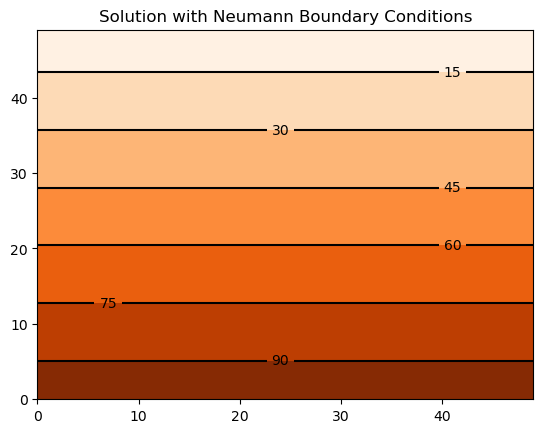

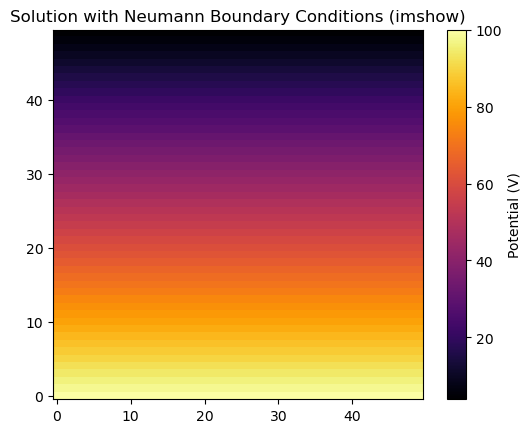

In [20]:
# Determine the range of potential values for Neumann solution
vmin, vmax = solution_neumann.min(), solution_neumann.max()

# Contour plot for Neumann boundary conditions
plt.figure()
plt.contourf(solution_neumann, alpha=1, cmap=plt.cm.Oranges, vmin=vmin, vmax=vmax)
C = plt.contour(solution_neumann, colors='black', vmin=vmin, vmax=vmax)
plt.clabel(C, inline=1)
plt.title('Solution with Neumann Boundary Conditions')
plt.show()

# Heatmap using imshow for Neumann solution
plt.figure()
plt.imshow(solution_neumann, cmap=plt.cm.inferno, origin='lower', vmin=vmin, vmax=vmax)
plt.title('Solution with Neumann Boundary Conditions (imshow)')
plt.colorbar(label='Potential (V)')
plt.show()

# Extra: Performance comparison of Numerical Methods
In this section, we will compare the performance of the Sparse Matrix method and the Jacobi method for solving the Laplace equation. Understanding the computational efficiency of these methods is crucial, especially when dealing with large-scale problems in scientific computing.

## Theoretical Background
The Sparse Matrix method and the Jacobi method are two distinct approaches to solving systems of linear equations that arise from discretizing the Laplace equation.

1. **Sparse Matrix Method**: This method involves constructing and directly solving a system of linear equations $ AV=b $ using techniques such as matrix inversion or LU decomposition. The time complexity of solving a system of linear equations directly is typically $O(n^3)$ for dense matrices, but by exploiting the sparsity of the matrix **$A$**, this can be reduced to around $O(N^2 log(N))$. Sparse matrix methods are often faster for smaller systems or when high precision is required, but their performance degrades as the size of the system increases due to the cubic dependence on the matrix size in dense cases or log-linear in sparse cases.

2. **Jacobi Method**: The Jacobi method is an iterative algorithm with a time complexity of approximately $O(N^2 \times k)$, where $k$ is the number of iterations required for convergence. Unlike direct methods, the Jacobi method is easier to parallelize and requires less memory, making it more suitable for very large systems where direct methods become impractical. However, the convergence rate of the Jacobi method can be slow, especially for poorly conditioned matrices, and it may require a large number of iterations to reach an acceptable solution.

## Performance Comparison Implementation
To compare the performance of these two methods, we will measure the time taken to solve the Laplace equation for a range of grid sizes. The code below implements this comparison:

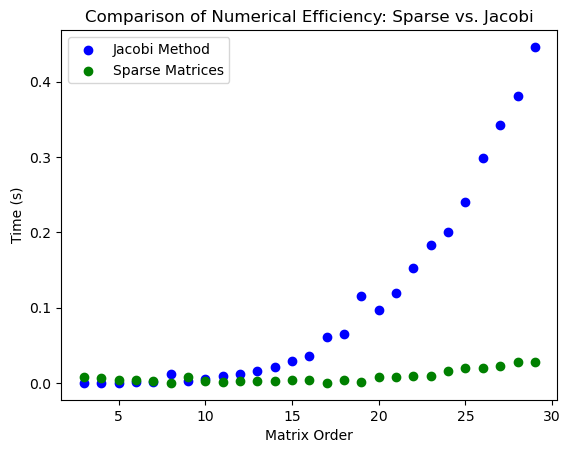

In [21]:
import time
import numpy as np
import matplotlib.pyplot as plt

# Define a range of matrix sizes to test
matrix_sizes = np.arange(3, 30, 1)
times_sparse = []
times_jacobi = []

# Measure the time taken by each method for each matrix size
for N in matrix_sizes:
    # Timing the Sparse Matrix Method
    start_time_sparse = time.time()
    solve_sparse_matrix(N)
    end_time_sparse = time.time()
    times_sparse.append(end_time_sparse - start_time_sparse)
    
    # Timing the Jacobi Method
    start_time_jacobi = time.time()
    jacobi_method(N)
    end_time_jacobi = time.time()
    times_jacobi.append(end_time_jacobi - start_time_jacobi)

# Plotting the performance comparison
plt.figure()
plt.scatter(matrix_sizes, times_jacobi, label='Jacobi Method', color='b')
plt.scatter(matrix_sizes, times_sparse, label='Sparse Matrices', color='g')
plt.xlabel('Matrix Order')
plt.ylabel('Time (s)')
plt.title('Comparison of Numerical Efficiency: Sparse vs. Jacobi')
plt.legend()
plt.show()

## Interpreting the results
From the plot, we can expect to see that the Sparse Matrix method performs better for smaller matrices due to its efficient handling of the sparse system. However, as the matrix size increases, the Jacobi method might become more competitive, particularly in cases where the matrix is very large and direct methods become computationally expensive.

The performance comparison gives us practical insights into when to use each method, balancing between computational efficiency and the size of the problem. This understanding is essential for making informed decisions in numerical simulations, where both the precision and computational cost must be carefully managed.